Compute the full dynamics induced by a two-body ising coulping Hamiltonian with heating rate, 
compare the result with the dynamics under a pure spin interaction approximation.

In [1]:
import numpy as np
from qutip import *
import matplotlib.pyplot as plt
import Qsim.operator.spin as spin
import Qsim.operator.phonon as phon
import Qsim.ion_chain.ising.ising_ps as iscp
import Qsim.ion_chain.ising.ising_c as iscc
import Qsim.operator.spin_phonon as sp_op
import Qsim.ion_chain.interaction.spin_phonon as Isp
from  Qsim.ion_chain.ion_system import *
from scipy import signal
import copy
import Qsim.ion_chain.interaction.dissipation as disp

In [2]:
#Simulation for a phonon system with dissipation only, check if the Lindbladian is working   
ion_sys = ions(trap_config={'N': 2, 'fx': 3, 'fz': 1}, 
                   numeric_config={'active_spin': [0],'active_phonon': [[0]], 'pcut': [[50]]},
                   )
ion_sys.list_para() #print parameters of the system

Trap coefficients updated
Anharmonic coefficients updated
_____________________________________________________________
Checking phonon space setup
Phonon space setups are consistent
_____________________________________________________________
Phonon space parameters updated
Cooling parameters updated
Trap parametric modulation updated
Ions class object initialized.
________________________________________________________________
********************Setup of the Trap************************
number of ions 2
Axial COM (Confining) frequency  1  [MHz]
Radial COM (Confining) frequency  3 [MHz]
Axial vibrational eigenfrequency [1.   1.73] MHz
Radial (Transverse) vibrational eigenfrequency [3.   2.83] [MHz]
Modulation Amplitude for parameteric amplification:  [0] [V]
Modulation Frequency for parameteric amplification:  [0] [MHz]
Trap dimension parameter:  200 [um]
                                                                 
********************Config of Numeric Calculation*************

In [3]:
#%%time evolution, assume the dissipation rate is 0.1 quanta/ms
clist = disp.heating(ion_sys,[0.1/(2*np.pi)],1) 
rho = sp_op.ini_state(ion_sys,[0],[[0]],0)
H0 = tensor(spin.zero_op(N=1),sp_op.p_zero(ion_sys))
times =  np.arange(0,1,10**(-4))
result0 = mesolve(H0,rho,times,clist,progress_bar=True,options=Options(nsteps=1000)) 

10.0%. Run time:   0.29s. Est. time left: 00:00:00:02
20.0%. Run time:   0.47s. Est. time left: 00:00:00:01
30.0%. Run time:   0.65s. Est. time left: 00:00:00:01
40.0%. Run time:   0.83s. Est. time left: 00:00:00:01
50.0%. Run time:   1.00s. Est. time left: 00:00:00:01
60.0%. Run time:   1.16s. Est. time left: 00:00:00:00
70.0%. Run time:   1.32s. Est. time left: 00:00:00:00
80.0%. Run time:   1.49s. Est. time left: 00:00:00:00
90.0%. Run time:   1.66s. Est. time left: 00:00:00:00
Total run time:   1.81s


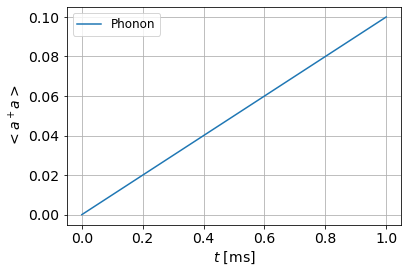

In [6]:
#%%plot phonon population 
df_p = 1 #for phonon measurements
pplot = expect(sp_op.phonon_measure(ion_sys,df_p, mindex=0), result0.states)
plt.plot(times,pplot,label = 'Phonon')
plt.xlabel(r'$t$ [ms]',fontsize = 14)
#title = r'$\delta_{com} = $'+str(ion_sys.delta)+' kHz'
plt.ylabel(r'$<a^+ a>$',fontsize = 14)
#plt.title(title,fontsize = 14)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.legend(fontsize = 12)
plt.grid()
plt.show()

In [7]:
#%%
'''
2body MS simulation for time-depedent Hamiltonian under RWA, drive the com mode,
first assume a small heating rate of 0.1 quanta/ms  
'''
com_cut = 10; tilt_cut = 3
ion_sys.update_numeric(numeric_config={'active_spin': [0,1],'active_phonon': [[0,1]], 'pcut': [[com_cut,tilt_cut]]})
Bz = 0 #Effective magnetic field
N = ion_sys.N
spin_config = np.array([0,0])
ion_sys.list_para()
#construct Hamiltonian 
laser1 = Laser(config = {'Omega_eff':30,'wavevector':1,'Dk':np.sqrt(2)*2*np.pi / (355*10**(-9)),
                         'laser_couple':[0,1], 'mu':50+1e3*ion_sys.fx,'phase':0})
laser1.list_para()
clist1 = disp.heating(ion_sys,[0.1/(2*np.pi),0],df=1) 
Heff,arg0 = iscc.H_ord(Bz,ion_sys,laser1) #construct time-dependent H
#construct initial state (initialized as up up)
rho1 = sp_op.ini_state(ion_sys,spin_config,[[0,0]],0)
elist1 = [tensor(spin.sz(N,0),sp_op.p_I(ion_sys)),tensor(spin.sz(N,1),sp_op.p_I(ion_sys)),
          sp_op.phonon_measure(ion_sys,df_p, mindex=0),
          sp_op.pstate_measure(ion_sys,df_p,com_cut-1,0)]
times =  np.arange(0,0.5,10**(-4))

_____________________________________________________________
Checking phonon space setup
Phonon space setups are consistent
_____________________________________________________________
Phonon space parameters updated
________________________________________________________________
********************Setup of the Trap************************
number of ions 2
Axial COM (Confining) frequency  1  [MHz]
Radial COM (Confining) frequency  3 [MHz]
Axial vibrational eigenfrequency [1.   1.73] MHz
Radial (Transverse) vibrational eigenfrequency [3.   2.83] [MHz]
Modulation Amplitude for parameteric amplification:  [0] [V]
Modulation Frequency for parameteric amplification:  [0] [MHz]
Trap dimension parameter:  200 [um]
                                                                 
********************Config of Numeric Calculation************************
index of phonon space included in simulation:  [[0, 1]]
corresonding phonon space cutoff  [[10, 3]]
********************Config of Cooling**

In [8]:
#solve time dependent ME
print('______________________________________________________________________')
print('solving for complete Hamiltonian')
result1 = mesolve(Heff,rho1,times,clist1,args = arg0,progress_bar=True,options=Options(nsteps=1000)) 

______________________________________________________________________
solving for complete Hamiltonian
10.0%. Run time:   5.52s. Est. time left: 00:00:00:49
20.0%. Run time:  11.14s. Est. time left: 00:00:00:44
30.0%. Run time:  16.85s. Est. time left: 00:00:00:39
40.0%. Run time:  22.77s. Est. time left: 00:00:00:34
50.0%. Run time:  28.53s. Est. time left: 00:00:00:28
60.0%. Run time:  34.01s. Est. time left: 00:00:00:22
70.0%. Run time:  39.62s. Est. time left: 00:00:00:16
80.0%. Run time:  45.15s. Est. time left: 00:00:00:11
90.0%. Run time:  50.59s. Est. time left: 00:00:00:05
Total run time:  56.26s


In [9]:
#simulation with a pure spin approximation
psi0 = spin.spin_state(N,[0,0])  
J = iscp.Jt(ion_sys,laser1)
elist2 = [spin.sz(N,0),spin.sz(N,1)]
H = iscp.Hps(J,ion_sys,Bz)
print('______________________________________________________________________')
print('solving for pure spin interaction')
result = mesolve(H,psi0,times,e_ops=elist2,progress_bar=True, options=Options(nsteps=1000))

______________________________________________________________________
solving for pure spin interaction
10.0%. Run time:   0.02s. Est. time left: 00:00:00:00
20.0%. Run time:   0.04s. Est. time left: 00:00:00:00
30.0%. Run time:   0.06s. Est. time left: 00:00:00:00
40.0%. Run time:   0.08s. Est. time left: 00:00:00:00
50.0%. Run time:   0.10s. Est. time left: 00:00:00:00
60.0%. Run time:   0.12s. Est. time left: 00:00:00:00
70.0%. Run time:   0.14s. Est. time left: 00:00:00:00
80.0%. Run time:   0.16s. Est. time left: 00:00:00:00
90.0%. Run time:   0.18s. Est. time left: 00:00:00:00
Total run time:   0.20s


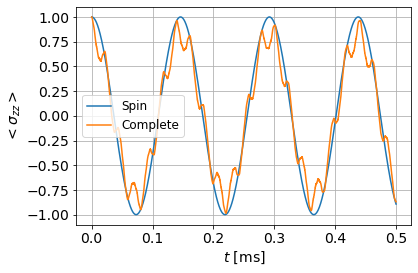

In [10]:
#plot spin dynamics
p0 = 0.5*(result.expect[0]+result.expect[1])
p1 = 0.5*(expect(elist1[0], result1.states)+expect(elist1[1], result1.states))
plt.plot(times,p0,label = 'Spin')
plt.plot(times,p1,label = 'Complete')
plt.xlabel(r'$t$ [ms]',fontsize = 14)
#title = r'$\delta_{com} = $'+str(ion_sys.delta)+' kHz'
plt.ylabel(r'$<\sigma_{zz}>$',fontsize = 14)
#plt.title(title,fontsize = 14)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.legend(fontsize = 12)
plt.grid()
plt.show()

Estimated phonon cutoff error:  3.4e-07


<Figure size 432x288 with 0 Axes>

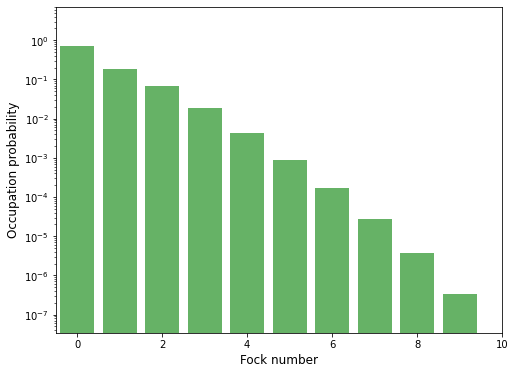

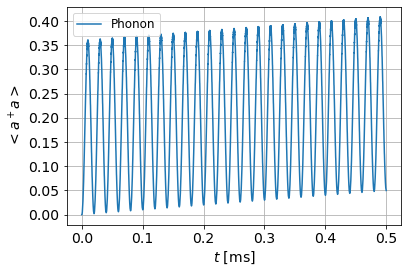

In [11]:
#%%plot phonon population 
sp_op.phonon_cutoff_error(result1.states, ion_sys, df=1, mindex=0,plot=True)
pplot = expect(elist1[2], result1.states)
plt.plot(times,pplot,label = 'Phonon')
plt.xlabel(r'$t$ [ms]',fontsize = 14)
#title = r'$\delta_{com} = $'+str(ion_sys.delta)+' kHz'
plt.ylabel(r'$<a^+ a>$',fontsize = 14)
#plt.title(title,fontsize = 14)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.legend(fontsize = 12)
plt.grid()
plt.show()

In [14]:
#%%simulate large heating rate, 3 quanta/ms, consider com mode only
com_cut = 50
ion_sys.pcut= [[com_cut]]; ion_sys.active_phonon=[[0]]
ion_sys.list_para()
#construct Hamiltonian 
clist1 = disp.heating(ion_sys,[3/(2*np.pi),0],df=1) 
Heff,arg0 = iscc.H_ord(Bz,ion_sys,laser1) #construct time-dependent H
#construct initial state (initialized as up up)
rho1 = sp_op.ini_state(ion_sys,spin_config,[[0,0]],0)
elist2 = [tensor(spin.sz(N,0),sp_op.p_I(ion_sys)),tensor(spin.sz(N,1),sp_op.p_I(ion_sys)),
          sp_op.phonon_measure(ion_sys,df_p, mindex=0),
          sp_op.pstate_measure(ion_sys,df_p,com_cut-1,0)]
times =  np.arange(0,0.5,10**(-4))

________________________________________________________________
********************Setup of the Trap************************
number of ions 2
Axial COM (Confining) frequency  1  [MHz]
Radial COM (Confining) frequency  3 [MHz]
Axial vibrational eigenfrequency [1.   1.73] MHz
Radial (Transverse) vibrational eigenfrequency [3.   2.83] [MHz]
Modulation Amplitude for parameteric amplification:  [0] [V]
Modulation Frequency for parameteric amplification:  [0] [MHz]
Trap dimension parameter:  200 [um]
                                                                 
********************Config of Numeric Calculation************************
index of phonon space included in simulation:  [[0]]
corresonding phonon space cutoff  [[50]]
********************Config of Cooling************************
Coolant index  [1]
********************Config of Trap Modulation************************
 Modulation Amplitude [0]  [V]
 Modulation Frequency [0]  [kHz]
 Trap dimension parameter 200  [um]


In [15]:
#solve time dependent ME
print('______________________________________________________________________')
print('solving for complete Hamiltonian')
result2 = mesolve(Heff,rho1,times,clist1,args = arg0,progress_bar=True,options=Options(nsteps=1000)) 

______________________________________________________________________
solving for complete Hamiltonian
10.0%. Run time:  10.85s. Est. time left: 00:00:01:37
20.0%. Run time:  21.40s. Est. time left: 00:00:01:25
30.0%. Run time:  31.07s. Est. time left: 00:00:01:12
40.0%. Run time:  41.36s. Est. time left: 00:00:01:02
50.0%. Run time:  51.35s. Est. time left: 00:00:00:51
60.0%. Run time:  61.41s. Est. time left: 00:00:00:40
70.0%. Run time:  71.81s. Est. time left: 00:00:00:30
80.0%. Run time:  81.97s. Est. time left: 00:00:00:20
90.0%. Run time:  92.19s. Est. time left: 00:00:00:10
Total run time: 102.36s


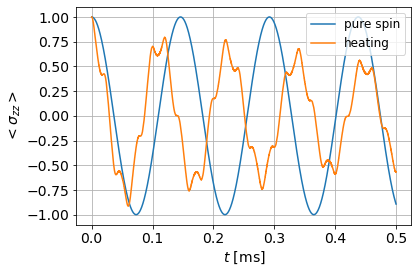

In [16]:
#plot spin dynamics
p2 = 0.5*(expect(elist2[0], result2.states)+expect(elist2[1], result2.states))
plt.plot(times,p0,label = 'pure spin')
plt.plot(times,p2,label = 'heating')
plt.xlabel(r'$t$ [ms]',fontsize = 14)
#title = r'$\delta_{com} = $'+str(ion_sys.delta)+' kHz'
plt.ylabel(r'$<\sigma_{zz}>$',fontsize = 14)
#plt.title(title,fontsize = 14)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.legend(fontsize = 12)
plt.grid()
plt.show()

Estimated phonon cutoff error:  7e-11


<Figure size 432x288 with 0 Axes>

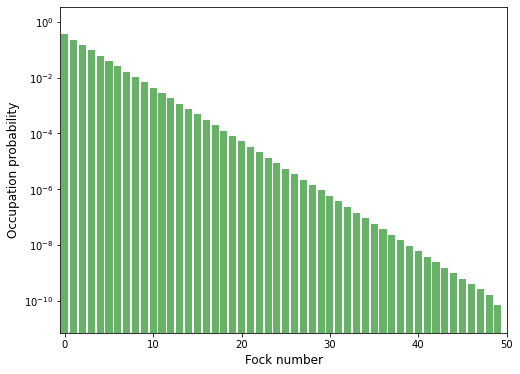

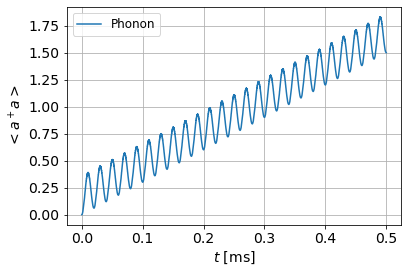

In [17]:
#%%plot phonon population 
sp_op.phonon_cutoff_error(result2.states, ion_sys, df=1, mindex=0,plot=True)
pplot2 = expect(elist2[2], result2.states)
plt.plot(times,pplot2,label = 'Phonon')
plt.xlabel(r'$t$ [ms]',fontsize = 14)
#title = r'$\delta_{com} = $'+str(ion_sys.delta)+' kHz'
plt.ylabel(r'$<a^+ a>$',fontsize = 14)
#plt.title(title,fontsize = 14)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.legend(fontsize = 12)
plt.grid()
plt.show()